# SWAG-approximated Bayesian Neural Network

Jax implementation of the SWAG method presented in [A Simple Baseline for Bayesian Uncertainty in Deep Learning](https://arxiv.org/abs/1902.02476) by Maddox, et.al.

In [266]:
import jax
import distrax
import optax
import jax.numpy as jnp
import flax.linen as nn
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.notebook import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree

In [267]:
%config InlineBackend.figure_format = "retina"

In [268]:
class MLP1D(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.Dense(10)(x)
        return x


class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = self.activation(x)
        x = nn.Dense(features=84)(x)
        x = self.activation(x)
        x = nn.Dense(features=self.num_classes)(x)
        x = nn.log_softmax(x)
        return x
        

def bnn_log_joint(params, X, y, model):
    flatten_params, _ = ravel_pytree(params)
    logits = model.apply(params, X)
    
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(y).sum()
    
    log_joint = log_prior + log_likelihood
    return log_joint

def bnn_loss_fn(params, X, y, model): return -bnn_log_joint(params, X, y, model)

In [269]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [270]:
key = jax.random.PRNGKey(314)
key_samples, key_init, key_train, key = jax.random.split(key, 4)

In [271]:
num_train = 2_000
X_train = jnp.array(mnist_train.data)[:num_train]
y_train = jnp.array(mnist_train.targets)[:num_train]

num_train, *_ = X_train.shape
# "Gaussanised" MNIST
X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, 10)
num_samples = len(X_train)

In [272]:
X_test = jnp.array(mnist_test.data)
y_test = jnp.array(mnist_test.targets)
n_test, *_ = X_test.shape

# X_test = X_test / xmax
# X_test = (X_test - xmean) / xstd

X_test = X_test[..., None]
X_test = X_test / 255
X_test = (X_test - xmean) / xstd

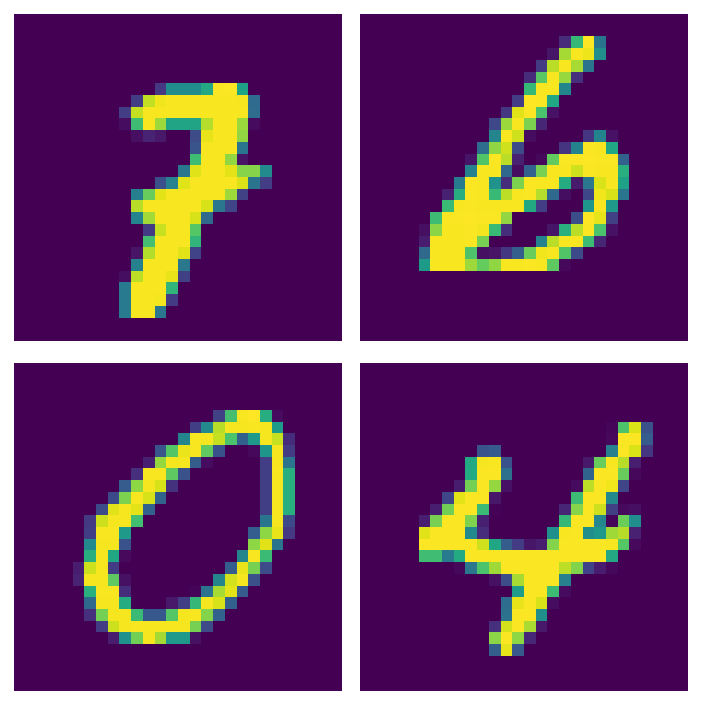

In [273]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, num_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(X_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [274]:
@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = partial(bnn_loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch_sgd(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    total_loss = 0
    num_batches = len(batch_ixs)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
        total_loss += loss
    
    mean_loss = total_loss / num_batches
    return params, opt_step, mean_loss

In [275]:
batch_size = 500
num_epochs = 150
learning_rate = 1e-5
tx = optax.adam(learning_rate=learning_rate)

model = SmallCNN(10)

batch = jnp.ones((batch_size, 28, 28, 1))
params = model.init(key_init, batch)
opt_state = tx.init(params)

losses = []

loss_old = jnp.inf
for e in tqdm(range(num_epochs)):
    _, key_train = jax.random.split(key_train)
    params, opt_state, loss = train_epoch_sgd(key_train, params, opt_state,
                                              X_train, y_ohe_train, batch_size, e)
    losses.append(loss)
    
    if abs(loss / loss_old - 1) < 1e-7:
        break
    else:
        loss_old = loss

  0%|          | 0/150 [00:00<?, ?it/s]

In [276]:
%%time
yhat_train = model.apply(params, X_train).argmax(axis=1)

CPU times: user 75.2 ms, sys: 9.8 ms, total: 85 ms
Wall time: 75.6 ms


In [277]:
acc_train = (y_train == yhat_train).mean()
print(f"{acc_train:0.2%}")
confusion_matrix(y_train, yhat_train)

83.10%


array([[178,   1,   1,   0,   0,   2,   5,   0,   4,   0],
       [  0, 213,   0,   1,   0,   0,   0,   0,   4,   2],
       [  3,  17, 136,   4,  14,   0,   4,   8,  12,   0],
       [  5,   5,   1, 163,   0,   1,   2,   3,   5,   6],
       [  1,   4,   0,   0, 187,   0,   4,   0,   0,  18],
       [  5,   8,   1,  30,   3, 120,   3,   0,   4,   6],
       [  4,  10,   1,   0,   2,   4, 176,   1,   1,   1],
       [  0,  11,   0,   1,   9,   0,   0, 195,   0,   8],
       [  1,  10,   3,   9,   0,   7,   3,   1, 125,  13],
       [  2,   3,   0,   6,  22,   0,   0,   7,   1, 169]])

## Swag

In [278]:
def get_swag_ixs(key, num_samples, batch_size, num_data_passes):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    keys = jax.random.split(key, num_data_passes)
    batches_fn = jax.vmap(get_batch_train_ixs, (0, None, None))
    batches_ix = batches_fn(keys, num_samples, batch_size)
    batches_ix = batches_ix.reshape(-1, batch_size)
    
    return batches_ix


def update_first_moment(moment, params, n):
    moment = jax.tree_map(lambda mean, theta: (n * mean + theta) / (n + 1),
                          moment, params)
    return moment


def update_second_moment(moment, params, n):
    moment = jax.tree_map(lambda mean2, theta: (n * mean2 + theta ** 2) / (n + 1),
                          moment, params)
    return moment


def train_step(params, opt_state, X_batch, y_batch, tx, loss_fn, model):
    loss_fn = partial(loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params

@jax.jit
def insert(storage, index, new_item, capacity):
    """
    Ring buffer implementation.
    """
    storage = storage.at[:, index].set(new_item)
    index = (index + 1) % capacity
    return storage, index

In [279]:
batches_ix = get_swag_ixs(key, num_samples, batch_size, 50)
update_freq = 10
T = len(batches_ix)

In [280]:
num_K = 50
learning_rate = 1e-4
tx_swag = optax.sgd(learning_rate=learning_rate)
train_step_part = jax.jit(partial(train_step, tx=tx_swag, loss_fn=bnn_loss_fn, model=model))


# SWAG - moment params
params_moment = params.copy({})
params_moment2 = jax.tree_map(lambda x: x ** 2, params)


params_swag = params.copy({})
opt_state_swag = tx_swag.init(params_swag)

# Initialise difference storage
index = 0
params_flat, *_ = ravel_pytree(params_moment)
num_params, *_ = params_flat.shape
D = jnp.empty((num_params, num_K))


for t, batch_ix in tqdm(enumerate(batches_ix), total=T):
    X_batch = X_train[batch_ix, ...]
    y_batch = y_ohe_train[batch_ix, ...]
    
    loss, params_swag = train_step_part(params_swag, opt_state_swag, X_batch, y_batch)
    
    if t % update_freq == 0:
        n = t // update_freq
        params_moment = update_first_moment(params_moment, params_swag, n)
        params_moment2 = update_second_moment(params_moment2, params_swag, n)
        
        params_diff = jax.tree_map(lambda x, y: x - y, params_swag, params_moment)
        params_diff, *_ = ravel_pytree(params_diff)
        D, index = insert(D, index, params_diff, num_K)

  0%|          | 0/200 [00:00<?, ?it/s]

In [281]:
cpu_device, *_ = jax.devices("cpu")
tpu_device, *_ = jax.devices("tpu")

params_swag = params_moment.copy({})
Sigma_diag = jax.tree_map(lambda w2, w: w2 - w ** 2, params_moment2, params_moment)
Sigma_diag, reconstruct_fn = ravel_pytree(Sigma_diag)

params_swag = jax.device_put(params_swag, cpu_device)
params_swag, _ = ravel_pytree(params_swag)
Sigma_diag = jax.device_put(Sigma_diag, cpu_device)

In [282]:
key_fulldim, key_subspace = jax.random.split(key)

In [283]:
num_swag_samples = 500
key_fulldim = jax.device_put(key_fulldim, cpu_device)
samples_fulldim = jax.random.normal(key_fulldim, (num_swag_samples, num_params))
samples_fulldim = jnp.einsum("nm,m->nm", samples_fulldim, jnp.sqrt(Sigma_diag / 2))


samples_subdim = jax.random.normal(key_fulldim, (num_swag_samples, num_K))
samples_subdim = jnp.einsum("nk,mk->nm", samples_subdim, D / jnp.sqrt(2 * num_K - 2))


posterior_samples = params_swag + (samples_subdim + samples_subdim)
del samples_fulldim, samples_subdim
reconstruct_fn_vmap = jax.vmap(reconstruct_fn)
posterior_samples = reconstruct_fn_vmap(posterior_samples)

In [284]:
X_train_cpu = jax.device_put(X_train, device=cpu_device)

In [285]:
model_apply_samples = jax.vmap(model.apply, (0, None), out_axes=1)
yhat_train_multiple = model_apply_samples(posterior_samples, X_train_cpu[:50]).argmax(axis=-1)

In [286]:
yhat_train_multiple.mean(axis=1).round().astype(int)

DeviceArray([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9,
             4, 0, 9, 1, 4, 2, 4, 3, 3, 7, 3, 8, 6, 7, 0, 5, 6, 0, 7, 6,
             1, 8, 7, 9, 3, 9, 8, 5, 5, 3], dtype=int32)

In [287]:
yhat_train[:50]

DeviceArray([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 1, 3, 6, 1, 7, 2, 8, 6, 1,
             4, 0, 9, 1, 1, 8, 9, 3, 7, 7, 3, 8, 6, 7, 8, 5, 6, 0, 7, 6,
             1, 8, 7, 9, 3, 9, 8, 5, 3, 3], dtype=int32)

## Test set

In [288]:
num_test = 5_000
X_test_cpu = jax.device_put(X_test, device=cpu_device)[:num_test]
yhat_test_multiple = model_apply_samples(posterior_samples, X_test_cpu)

tcmalloc: large alloc 47040004096 bytes == 0x56045261a000 @  0x7fb3a58e8680 0x7fb3a5909824 0x7fb3a5909b8a 0x7fb39afedff4 0x7fb3970ee92f 0x7fb3970fa30c 0x7fb3970fd9e5 0x7fb39704737a 0x7fb396da1f68 0x7fb396d8600b 0x55ed25fd3714 0x55ed25fa39ef 0x55ed25f34e19 0x55ed25f58fdc 0x55ed25fe1b0d 0x55ed25fe2527 0x55ed25edec17 0x55ed25edf1eb 0x55ed25f978f8 0x55ed2602b740 0x55ed25fe1b0d 0x55ed25fe2527 0x55ed25f978f8 0x55ed2602b740 0x55ed25fe18e2 0x55ed25fe2527 0x55ed25edec17 0x55ed26068592 0x55ed25f977f7 0x55ed2602b740 0x55ed25fe2753
tcmalloc: large alloc 47040004096 bytes == 0x561a1d286000 @  0x7fb3a58e8680 0x7fb3a5909824 0x7fb39785cee5 0x7fb3978e448b 0x7fb3978e4af9 0x7fb0db10b0a3 0x7fb3970fd9e5 0x7fb39704737a 0x7fb396da1f68 0x7fb396d8600b 0x55ed25fd3714 0x55ed25fa39ef 0x55ed25f34e19 0x55ed25f58fdc 0x55ed25fe1b0d 0x55ed25fe2527 0x55ed25edec17 0x55ed25edf1eb 0x55ed25f978f8 0x55ed2602b740 0x55ed25fe1b0d 0x55ed25fe2527 0x55ed25f978f8 0x55ed2602b740 0x55ed25fe18e2 0x55ed25fe2527 0x55ed25edec17 0x55ed26

In [289]:
acc_test_multiple = yhat_test_multiple.argmax(axis=-1) == y_test[:num_test, None]
acc_test_avg = acc_test_multiple.mean()
print(f"Average accuracy: {acc_test_avg:0.2%}")

Average accuracy: 86.40%


### SWAG - test results

In [290]:
yhat_test = yhat_test_multiple.mean(axis=1).argmax(axis=-1)
acc_test = (y_test[:num_test] == yhat_test).mean()
print(f"{acc_test:0.2%}")
confusion_matrix(y_test[:num_test], yhat_test)

88.44%


array([[443,   0,   5,   0,   1,   2,   6,   0,   3,   0],
       [  0, 560,   3,   2,   0,   0,   3,   1,   2,   0],
       [  1,   2, 481,   7,   9,   0,   7,  14,   9,   0],
       [  2,   3,  13, 409,   0,  44,   1,  16,  10,   2],
       [  0,   1,   1,   1, 460,   0,  12,   1,   2,  22],
       [  4,   3,   2,  10,   9, 398,   7,  11,   4,   8],
       [  8,   3,  23,   1,  12,  13, 401,   0,   1,   0],
       [  0,  14,  28,   5,   8,   0,   0, 433,   3,  21],
       [  8,   6,  10,  20,  11,  15,   8,  10, 391,  10],
       [  4,   5,   4,  13,  27,   0,   1,  17,   3, 446]])

### SGD - test results

In [291]:
yhat_test_sgd = model.apply(params, X_test).argmax(axis=1)[:num_test]

acc_test_sgd = (y_test[:num_test] == yhat_test_sgd).mean()
print(f"{acc_test_sgd:0.2%}")
confusion_matrix(y_test[:num_test], yhat_test_sgd)

76.24%


array([[430,   0,   0,   3,   1,   2,  16,   0,   7,   1],
       [  0, 556,   1,   3,   0,   0,   3,   0,   2,   6],
       [ 13,  39, 355,  31,  13,   0,   9,  19,  46,   5],
       [  3,  12,   7, 402,   2,  25,   6,  13,  19,  11],
       [  1,   6,   0,   0, 397,   0,  13,   4,   0,  79],
       [ 13,  11,   3,  99,  15, 234,   7,  13,  24,  37],
       [ 22,  19,  26,   0,  14,  34, 341,   3,   2,   1],
       [  1,  41,   7,   1,  14,   0,   1, 416,   5,  26],
       [  8,  22,  10,  32,   5,  30,  10,  10, 292,  70],
       [  7,  16,   2,  13,  72,   0,   2,  17,   2, 389]])

## Distribution over predictions

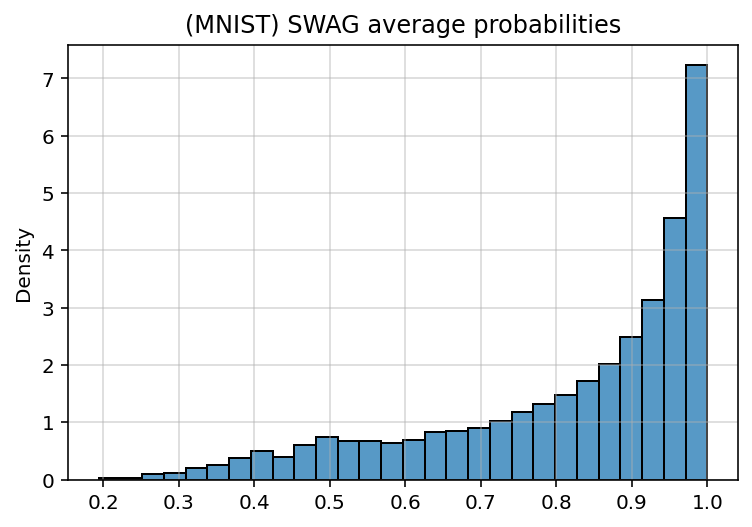

In [317]:
pred_probs = jax.nn.softmax(yhat_test_multiple, axis=-1).mean(axis=1).max(axis=-1)
plt.title("(MNIST) SWAG average probabilities")
sns.histplot(pred_probs, stat="density")
plt.grid(alpha=0.5)

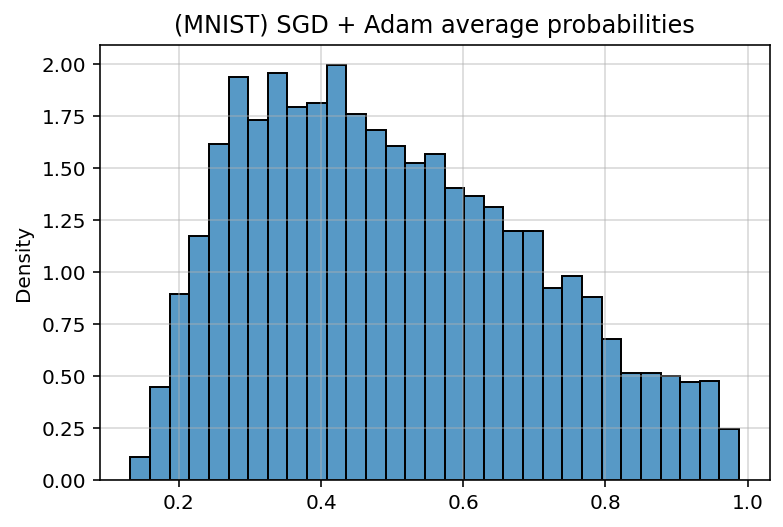

In [318]:
pred_probs = jax.nn.softmax(model.apply(params, X_test)).max(axis=1)
plt.title("(MNIST) SGD + Adam average probabilities")
sns.histplot(pred_probs, stat="density")
plt.grid(alpha=0.5)

# Out-of-distribution (OOD) SWAG?

In this section, we analise the performance of SWAG when tested on OOD data. See [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book2/19/bnn_mnist_sgld_blackjax.ipynb) for reference.

In [306]:
from torchvision.datasets import FashionMNIST

In [307]:
root = "/tmp/fashion-mnist"
fashion_mnist_train = FashionMNIST(root, download=True, train=True)
fashion_mnist_test = FashionMNIST(root, download=True, train=False)

In [308]:
fX_test = jnp.array(fashion_mnist_test.data)
fy_test = jnp.array(fashion_mnist_test.targets)
n_test, *_ = fX_test.shape

xmean = fX_test.mean()
xstd = fX_test.std()

fX_test = fX_test[..., None]
fX_test = fX_test / 255
fX_test = (fX_test - xmean) / xstd

In [ ]:
num_test = 5_000
fX_test_cpu = jax.device_put(fX_test, device=cpu_device)[:num_test]
fyhat_test_multiple = model_apply_samples(posterior_samples, fX_test_cpu)

In [312]:
acc_test_multiple = fyhat_test_multiple.argmax(axis=-1) == fy_test[:num_test, None]
acc_test_avg = acc_test_multiple.mean()
print(f"Average accuracy: {acc_test_avg:0.2%}")

Average accuracy: 9.62%


### SWAG – test results 

In [314]:
fyhat_test = fyhat_test_multiple.mean(axis=1).argmax(axis=-1)
acc_test = (fy_test[:num_test] == fyhat_test).mean()
print(f"{acc_test:0.2%}")
confusion_matrix(fy_test[:num_test], fyhat_test)

9.62%


array([[  0, 507,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 481,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 521,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 521,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 485,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 482,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 526,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 477,   0,   0,   0,   0,   0,   0,   0,   0]])

### SGD + Adam – test results

In [319]:
fyhat_test_sgd = model.apply(params, fX_test).argmax(axis=1)[:num_test]

acc_test_sgd = (y_test[:num_test] == fyhat_test_sgd).mean()
print(f"{acc_test_sgd:0.2%}")
confusion_matrix(fy_test[:num_test], fyhat_test_sgd)

11.42%


array([[  0, 507,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 481,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 521,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 521,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 485,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 482,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 500,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 526,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 477,   0,   0,   0,   0,   0,   0,   0,   0]])

## Samples histogram 

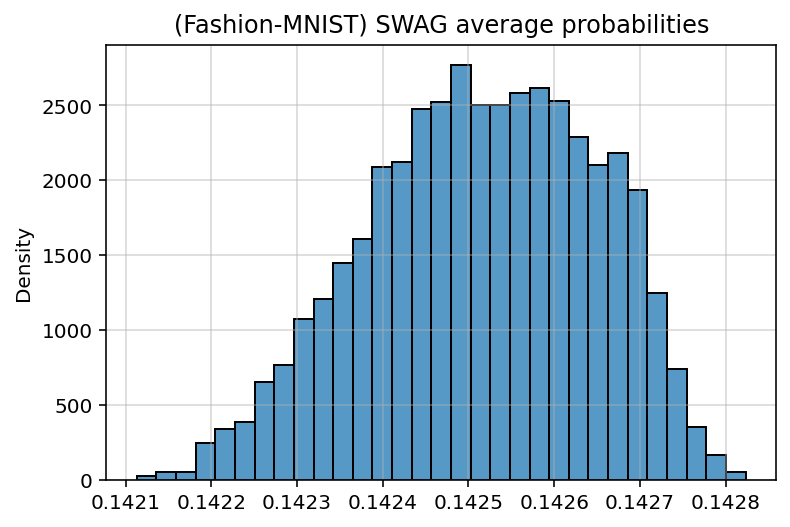

In [323]:
pred_probs = jax.nn.softmax(fyhat_test_multiple, axis=-1).mean(axis=1).max(axis=-1)
plt.title("(Fashion-MNIST) SWAG average probabilities")
sns.histplot(pred_probs, stat="density")
plt.grid(alpha=0.5)

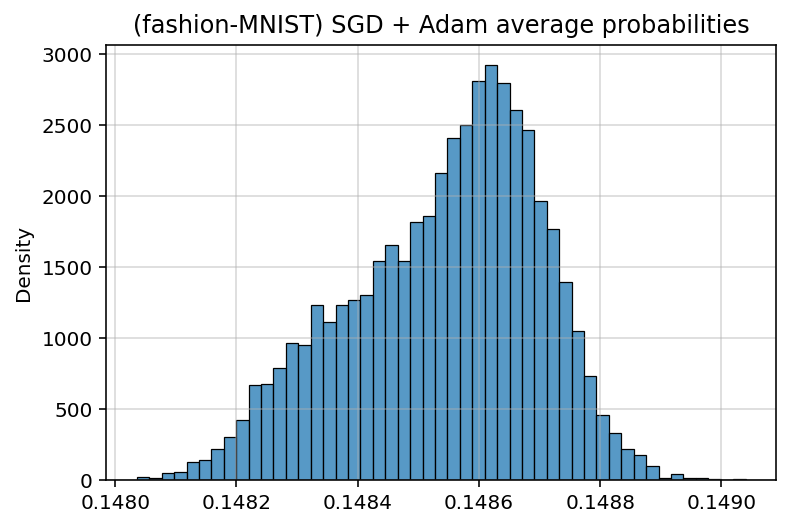

In [322]:
pred_probs = jax.nn.softmax(model.apply(params, fX_test)).max(axis=1)
plt.title("(fashion-MNIST) SGD + Adam average probabilities")
sns.histplot(pred_probs, stat="density")
plt.grid(alpha=0.5)